# General Introduction to Reservoir Computing

## Summary

- <a href="#chapter1">Chapter 1 : A simple task</a>
- <a href="#chapter2">Chapter 2 : Generative models</a>
- <a href="#chapter3">Chapter 3 : Online learning</a>

In [ ]:
%pip install reservoirpy

In [1]:
import numpy as np

import matplotlib.pyplot as plt

import reservoirpy as rpy

# just a little tweak to center the plots, nothing to worry about
from IPython.core.display import HTML
HTML("""
<style>
.img-center {
    display: block;
    margin-left: auto;
    margin-right: auto;
    }
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
    }
</style>
""")

rpy.set_seed(42)

## Chapter 1 : Reservoir Computing for chaotic timeseries forecasting <span id="chapter1"/>

**Mackey-Glass timeseries**

Mackey-Glass equation are a set of delayed differential equations
describing the temporal behavior of different physiological signal,
for example, the relative quantity of mature blood cells over time.

The equations are defined as:

$$
\frac{dP(t)}{dt} = \frac{a P(t - \tau)}{1 + P(t - \tau)^n} - bP(t)
$$

where $a = 0.2$, $b = 0.1$, $n = 10$, and the time delay $\tau = 17$.
$\tau$ controls the chaotic behavior of the equations (the higher it is,
the more chaotic the timeseries becomes.
$\tau=17$ already gives good chaotic results.)

In [2]:
from reservoirpy.datasets import mackey_glass
from reservoirpy.observables import nrmse, rsquare

timesteps = 2510
tau = 17
X = mackey_glass(timesteps, tau=tau)

# rescale between -1 and 1
X = 2 * (X - X.min()) / (X.max() - X.min()) - 1

In [3]:
def plot_mackey_glass(X, sample, tau):

    fig = plt.figure(figsize=(13, 5))
    N = sample

    ax = plt.subplot((121))
    t = np.linspace(0, N, N)
    for i in range(N-1):
        ax.plot(t[i:i+2], X[i:i+2], color=plt.cm.magma(255*i//N), lw=1.0)

    plt.title(f"Timeseries - {N} timesteps")
    plt.xlabel("$t$")
    plt.ylabel("$P(t)$")

    ax2 = plt.subplot((122))
    ax2.margins(0.05)
    for i in range(N-1):
        ax2.plot(X[i:i+2], X[i+tau:i+tau+2], color=plt.cm.magma(255*i//N), lw=1.0)

    plt.title(f"Phase diagram: $P(t) = f(P(t-\\tau))$")
    plt.xlabel("$P(t-\\tau)$")
    plt.ylabel("$P(t)$")

    plt.tight_layout()
    plt.show()

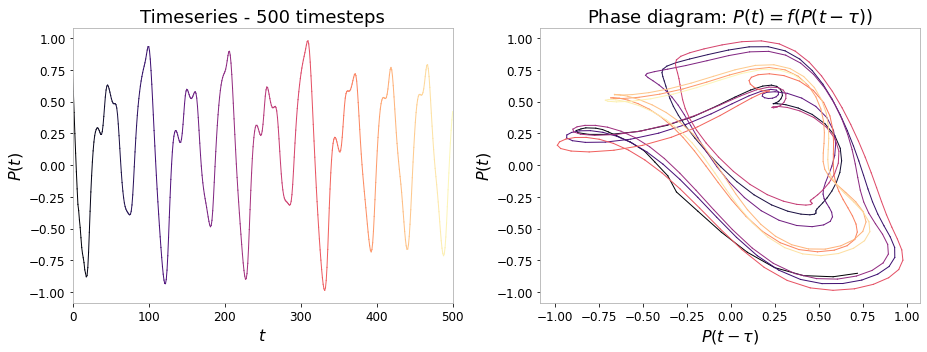

In [4]:
plot_mackey_glass(X, 500, tau)

- Not completely unpredictable... (not random)
- ...but not easily predictable (not periodic)
- Similar to ECG rhythms, stocks, weather...

### 1.1. Task 1: 10 timesteps ahead forecast

Predict $P(t + 10)$ given $P(t)$.

#### Data preprocessing

In [5]:
def plot_train_test(X_train, y_train, X_test, y_test):
    sample = 500
    test_len = X_test.shape[0]
    fig = plt.figure(figsize=(15, 5))
    plt.plot(np.arange(0, 500), X_train[-sample:], label="Training data")
    plt.plot(np.arange(0, 500), y_train[-sample:], label="Training ground truth")
    plt.plot(np.arange(500, 500+test_len), X_test, label="Testing data")
    plt.plot(np.arange(500, 500+test_len), y_test, label="Testing ground truth")
    plt.legend()
    plt.show()

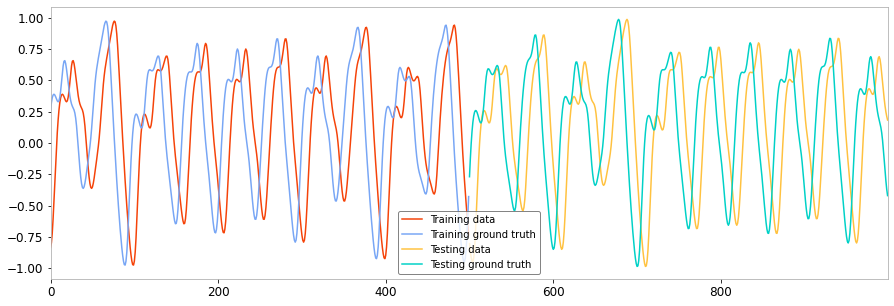

In [6]:
from reservoirpy.datasets import to_forecasting

x, y = to_forecasting(X, forecast=10)
X_train1, y_train1 = x[:2000], y[:2000]
X_test1, y_test1 = x[2000:], y[2000:]

plot_train_test(X_train1, y_train1, X_test1, y_test1)

### Build your first Echo State Network

In [7]:
units = 100
leak_rate = 0.3
spectral_radius = 1.25
input_scaling = 1.0
connectivity = 0.1
input_connectivity = 0.2
regularization = 1e-8
seed = 1234

In [8]:
def reset_esn():
    from reservoirpy.nodes import Reservoir, Ridge

    reservoir = Reservoir(units, input_scaling=input_scaling, sr=spectral_radius,
                          lr=leak_rate, rc_connectivity=connectivity,
                          input_connectivity=input_connectivity, seed=seed)
    readout   = Ridge(ridge=regularization, output_dim=1)

    return reservoir >> readout

In [9]:
from reservoirpy.nodes import Reservoir, Ridge

reservoir = Reservoir(units, input_scaling=input_scaling, sr=spectral_radius,
                      lr=leak_rate, rc_connectivity=connectivity,
                      input_connectivity=input_connectivity, seed=seed)

readout   = Ridge(ridge=regularization, output_dim=1)

esn = reservoir >> readout

#### ESN training

Training is performed *offline*: it happens only once on the whole dataset.

In [10]:
esn = esn.fit(X_train1, y_train1)

In [11]:
def plot_readout(readout):
    Wout = readout.Wout
    bias = readout.bias
    Wout = np.r_[bias[..., np.newaxis], Wout]

    fig = plt.figure(figsize=(15, 5))

    ax = fig.add_subplot(111)
    ax.grid(axis="y")
    ax.set_ylabel("Coefs. of $W_{out}$")
    ax.set_xlabel("reservoir neurons index")
    ax.bar(np.arange(Wout.size), Wout.ravel()[::-1])

    plt.show()

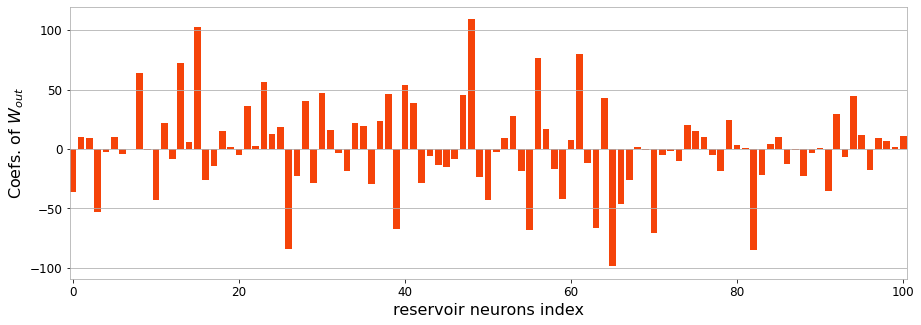

In [12]:
plot_readout(readout)

#### ESN test

In [13]:
def plot_results(y_pred, y_test, sample=500):

    fig = plt.figure(figsize=(15, 7))
    plt.subplot(211)
    plt.plot(np.arange(sample), y_pred[:sample], lw=3, label="ESN prediction")
    plt.plot(np.arange(sample), y_test[:sample], linestyle="--", lw=2, label="True value")
    plt.plot(np.abs(y_test[:sample] - y_pred[:sample]), label="Absolute deviation")

    plt.legend()
    plt.show()

In [14]:
y_pred1 = esn.run(X_test1)

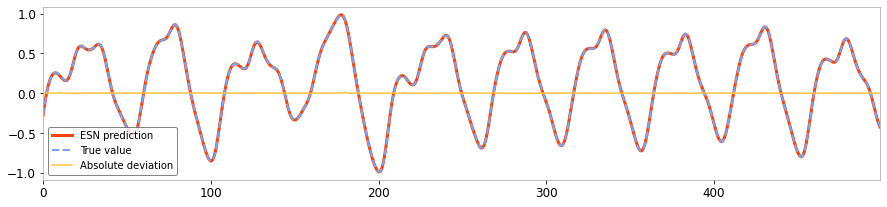

In [15]:
plot_results(y_pred1, y_test1)

$R^2$ and NRMSE :

In [16]:
print(f"R2 = {rsquare(y_test1, y_pred1):.5}, NRMSE = {nrmse(y_test1, y_pred1):.5}")

R2 = 0.99918, NRMSE = 0.006855


### 1.2 Make the task harder

Now, let's have a forecasting horizon of 100 timesteps.

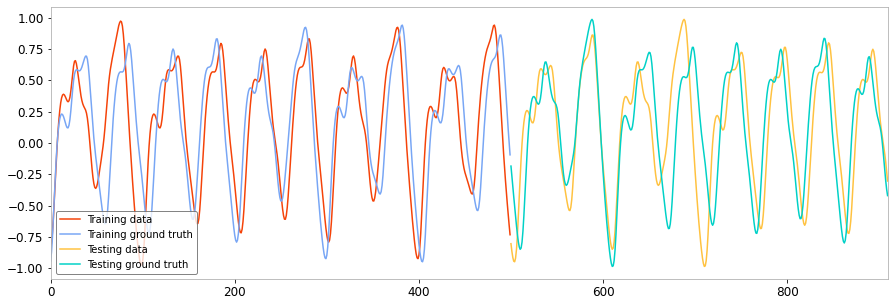

In [17]:
x, y = to_forecasting(X, forecast=100)
X_train2, y_train2 = x[:2000], y[:2000]
X_test2, y_test2 = x[2000:], y[2000:]

plot_train_test(X_train2, y_train2, X_test2, y_test2)

In [18]:
y_pred2 = esn.fit(X_train2, y_train2).run(X_test2)

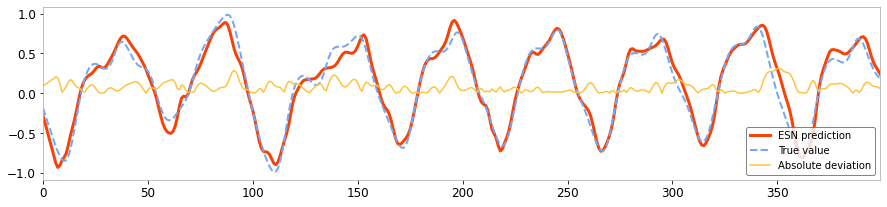

In [19]:
plot_results(y_pred2, y_test2, sample=400)

$R^2$ and NRMSE:

In [20]:
print(f"R2 = {rsquare(y_test2, y_pred2):.5}, NRMSE = {nrmse(y_test2, y_pred2):.5}")

R2 = 0.95083, NRMSE = 0.054411


## Chapter 2 : Use generative mode <span id="chapter2"/>

- Train ESN on a one-timestep-ahead forecasting task.
- Run the ESN on its own predictions (closed loop generative mode)

In [21]:
units = 500
leak_rate = 0.3
spectral_radius = 0.99
input_scaling = 1.0
connectivity = 0.1      # - density of reservoir internal matrix
input_connectivity = 0.2  # and of reservoir input matrix
regularization = 1e-4
seed = 1234             # for reproducibility

In [22]:
def plot_generation(X_gen, X_t, nb_generations, warming_out=None, warming_inputs=None, seed_timesteps=0):

    plt.figure(figsize=(15, 5))
    if warming_out is not None:
        plt.plot(np.vstack([warming_out, X_gen]), label="Generated timeseries")
    else:
        plt.plot(X_gen, label="Generated timeseries")

    plt.plot(np.arange(nb_generations)+seed_timesteps, X_t, linestyle="--", label="Real timeseries")

    if warming_inputs is not None:
        plt.plot(np.arange(seed_timesteps), warming_inputs, linestyle="--", label="Warmup")

    plt.plot(np.arange(nb_generations)+seed_timesteps, np.abs(X_t - X_gen),
             label="Absolute deviation")

    if seed_timesteps > 0:
        plt.fill_between([0, seed_timesteps], *plt.ylim(), facecolor='lightgray', alpha=0.5, label="Warmup")

    plt.plot([], [], ' ', label=f"$R^2 = {round(rsquare(X_t, X_gen), 4)}$")
    plt.plot([], [], ' ', label=f"$NRMSE = {round(nrmse(X_t, X_gen), 4)}$")
    plt.legend()
    plt.show()

#### Training for one-timestep-ahead forecast

In [23]:
esn = reset_esn()

x, y = to_forecasting(X, forecast=1)
X_train3, y_train3 = x[:2000], y[:2000]
X_test3, y_test3 = x[2000:], y[2000:]

esn = esn.fit(X_train3, y_train3)

#### Generative mode

- 100 steps of the real timeseries used as warmup.
- 300 steps generated by the reservoir, without external inputs.

In [24]:
seed_timesteps = 100

warming_inputs = X_test3[:seed_timesteps]

esn.nodes[0].reset()
warming_out = esn.run(warming_inputs)  # warmup

In [25]:
nb_generations = 400

X_gen = np.zeros((nb_generations, 1))
y = warming_out[-1]
for t in range(nb_generations):  # generation
    y = esn(y)
    X_gen[t, :] = y

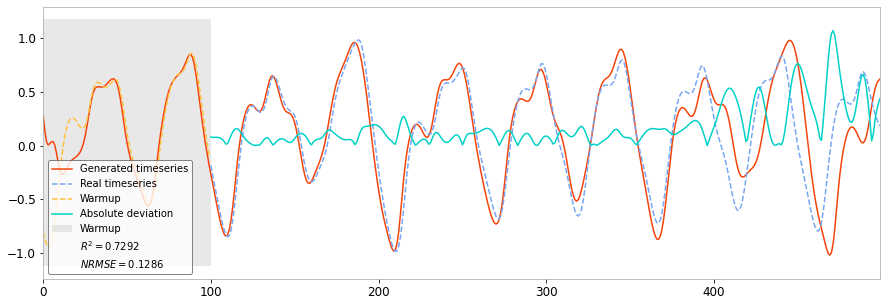

In [26]:
X_t = X_test3[seed_timesteps: nb_generations+seed_timesteps]
plot_generation(X_gen, X_t, nb_generations, warming_out=warming_out,
                warming_inputs=warming_inputs, seed_timesteps=seed_timesteps)

## Chapter 3 : Online learning <span id="chapter3"/>

Some learning rules allow to update the readout parameters at every timestep of input series.

Using **FORCE** algorithm *(Sussillo and Abott, 2009)*

<div>
    <img src="./static/online.png" width="700">
</div>

In [27]:
units = 100
leak_rate = 0.3
spectral_radius = 1.25
input_scaling = 1.0
connectivity = 0.1
input_connectivity = 0.2
seed = 1234

In [28]:
from reservoirpy.nodes import RLS

reservoir = Reservoir(units, input_scaling=input_scaling, sr=spectral_radius,
                      lr=leak_rate, rc_connectivity=connectivity,
                      input_connectivity=input_connectivity, seed=seed)

readout   = RLS(1)


esn_online = reservoir >> readout

#### Step by step training

In [29]:
outputs_pre = np.zeros(X_train1.shape)
for t, (x, y) in enumerate(zip(X_train1, y_train1)): # for each timestep of training data:
    outputs_pre[t, :] = esn_online.partial_fit(x.reshape(-1, 1), y.reshape(-1, 1))

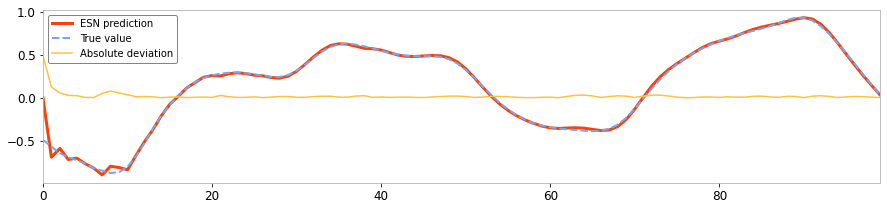

In [30]:
plot_results(outputs_pre, y_train1, sample=100)

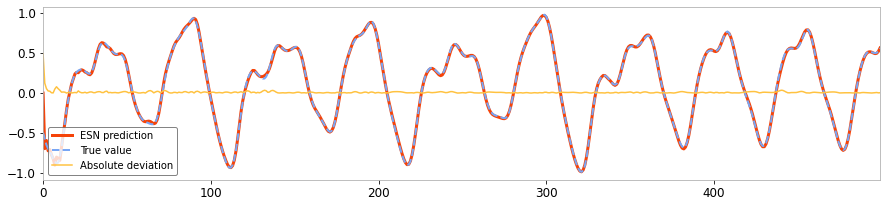

In [31]:
plot_results(outputs_pre, y_train1, sample=500)

#### Training on a whole timeseries

In [32]:
reservoir = Reservoir(units, input_scaling=input_scaling, sr=spectral_radius,
                      lr=leak_rate, rc_connectivity=connectivity,
                      input_connectivity=input_connectivity, seed=seed)

readout   = RLS(1)


esn_online = reservoir >> readout

In [33]:
esn_online.partial_fit(X_train1, y_train1)

pred_online = esn_online.run(X_test1)  # Wout est maintenant figée

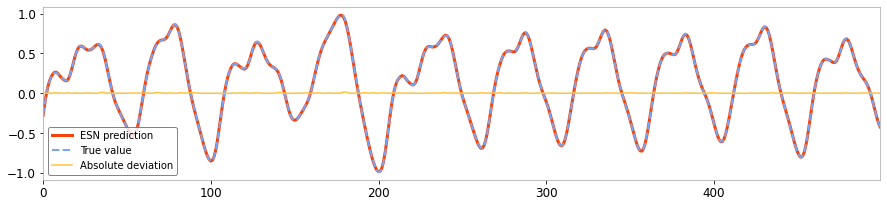

In [34]:
plot_results(pred_online, y_test1, sample=500)

$R^2$ and NRMSE:

In [35]:
print(f"R2 = {rsquare(y_test1, pred_online):.5}, NRMSE = {nrmse(y_test1, pred_online):.5}")

R2 = 0.94492, NRMSE = 0.056023


## Other timeseries

Try out the other chaotic timeseries included in ReservoirPy: Lorenz chaotic attractor, Hénon map, Logistic map, Double scroll attractor...